In [1]:
"""
Imports for building a deep learning model using PyTorch, Torchvision, and other essential libraries.

- PyTorch: Provides deep learning functionality, including neural networks, optimization, and custom datasets.
- Torchvision: Contains utilities for vision-based tasks, including datasets and image transformations.
- Image handling and visualization: Libraries for handling and displaying images.
- Data manipulation: Libraries for handling data, file processing, and randomization.
"""

# PyTorch core imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

# Torchvision imports for vision-based tasks
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights

# Sci-kit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Image handling and visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Data manipulation and file handling
import numpy as np
import pandas as pd
import os  # Operating system interface for directory management
import copy

# Randomization
import random
from random import shuffle, seed  # Random shuffling and seeding for reproducibility

In [2]:
torch.cuda.empty_cache()  # Free unused memory

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
TRAIN_DIR = './data/data_256'

In [5]:
def count_files_in_dir(directory):
    '''
    Counts the number of files in each subdirectory of the given directory,
    returning a DataFrame with folder names, subfolder names, and their image counts.

    Type 'quit' to exit, or 'default' to display all folders.

    Args:
        directory (str): The path to the main directory containing subfolders.

    Returns:
        df (pd.DataFrame): DataFrame containing folder names, subfolder names, and image counts.
    '''
    data = []

    # Iterate through subdirectories (folders)
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)

        # Check if it's a directory (i.e., a folder)
        if os.path.isdir(folder_path):
            # Iterate through subdirectories (subfolders)
            for subdir in os.listdir(folder_path):
                subdir_path = os.path.join(folder_path, subdir)

                # Check if it's a directory (i.e., a subfolder)
                if os.path.isdir(subdir_path):
                    # Count number of files in the subdirectory
                    file_count = len(os.listdir(subdir_path))
                    data.append({'Folder': folder, 'Subfolder': subdir, 'Image Count': file_count})

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)

    user_input = input("Enter your choice: ").strip().lower()

    if user_input == 'quit':
        print("Exiting the program.")
        return None  # or you can raise an exception or return a specific value if needed
    elif user_input == 'default':
        pd.set_option('display.max_rows', None)  # Show all rows in DataFrame
        return df
    elif user_input.isalpha() and len(user_input) == 1:
        # Display the selected folder's subfolders
        filtered_df = df[df['Folder'].str.lower() == user_input]  # Filter by folder
        if not filtered_df.empty:
            pd.set_option('display.max_rows', None)  # Show all rows in DataFrame
            return filtered_df
        else:
            print(f"No subfolders found for folder: {user_input}")
            return None  # or handle this case as needed
    else:
        print("Invalid input. Please enter a valid folder letter or 'quit'.")
        return None  # or handle this case as needed

In [6]:
# Count files in train and test directories
train_class_counts = count_files_in_dir(TRAIN_DIR)
train_class_counts

,Folder,Subfolder,Image Count
0,a,airfield,5000
1,a,airplane_cabin,5000
2,a,airport_terminal,5000
3,a,alcove,5000
4,a,alley,5000
5,a,amphitheater,5000
6,a,amusement_arcade,5000
7,a,amusement_park,5000
8,a,aquarium,5000
9,a,aqueduct,5000


In [7]:
class CustomDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        """
        Args:
            image_label_list (list of tuples): List where each tuple is (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_list = image_label_list
        self.transform = transform
    
    def __len__(self):
        return len(self.image_label_list)
    
    def __getitem__(self, idx):
        img_path, label = self.image_label_list[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image if loading fails
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, label

def load_preprocess_resnet18(train_dir, batch_size=64, val_size=0.2, test_size=0.1, num_classes=5):
    '''
    Load and preprocess the data by randomly selecting a specified number of classes
    from the full dataset and splitting it into training, validation, and test sets.
    Labels are remapped to ensure they are contiguous (0, 1, 2, ..., num_classes-1).

    Args:
        train_dir (str): Path to the training data directory.
        batch_size (int): The batch size for the DataLoader.
        val_size (float): Proportion of the dataset to be used as validation data.
        test_size (float): Proportion of the dataset to be used as test data.
        num_classes (int): Number of random classes to select from the dataset.

    Returns:
        tuple: DataLoader for training, validation, and test datasets, and list of selected class names.
    '''
    
    # Define the transformations for ResNet18
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
    ])
    
    # Step 1: Collect all class names and image paths
    class_names = []
    class_to_images = {}
    
    for letter in os.listdir(train_dir):
        letter_dir = os.path.join(train_dir, letter)
        if os.path.isdir(letter_dir):
            for class_name in os.listdir(letter_dir):
                class_dir = os.path.join(letter_dir, class_name)
                if os.path.isdir(class_dir):
                    class_names.append(class_name)
                    image_files = [
                        os.path.join(class_dir, img) for img in os.listdir(class_dir)
                        if img.lower().endswith(('.png', '.jpg', '.jpeg'))
                    ]
                    class_to_images[class_name] = image_files
    
    print(f"Total classes found: {len(class_names)}")
    
    # Step 2: Randomly select num_classes
    if num_classes > len(class_names):
        raise ValueError(f"num_classes={num_classes} exceeds available classes={len(class_names)}")
    
    selected_classes = random.sample(class_names, num_classes)
    print(f"Selected classes: {selected_classes}")
    
    # Step 3: Collect image paths and assign new labels
    selected_class_to_idx = {class_name: idx for idx, class_name in enumerate(selected_classes)}
    image_label_list = []
    
    for class_name in selected_classes:
        image_paths = class_to_images[class_name]
        for img_path in image_paths:
            image_label_list.append((img_path, selected_class_to_idx[class_name]))
    
    print(f"Number of filtered samples: {len(image_label_list)}")
    
    if len(image_label_list) == 0:
        raise ValueError("No images found for the selected classes.")
    
    # Step 4: Split into train, val, test
    # Extract labels for stratification
    labels = [label for _, label in image_label_list]
    
    # First split: train and temp (val + test)
    train_indices, temp_indices, train_labels, temp_labels = train_test_split(
        list(range(len(image_label_list))),
        labels,
        test_size=(val_size + test_size),
        random_state=42,
        stratify=labels
    )
    
    # Calculate relative size for validation
    relative_val_size = val_size / (val_size + test_size)
    
    # Second split: val and test
    val_indices, test_indices, _, _ = train_test_split(
        temp_indices,
        [labels[i] for i in temp_indices],
        test_size=(test_size / (val_size + test_size)),
        random_state=42,
        stratify=[labels[i] for i in temp_indices]
    )
    
    print(f"Train samples: {len(train_indices)}, Validation samples: {len(val_indices)}, Test samples: {len(test_indices)}")
    
    # Create subset datasets
    train_subset = Subset(CustomDataset(image_label_list, transform=transform), train_indices)
    val_subset = Subset(CustomDataset(image_label_list, transform=transform), val_indices)
    test_subset = Subset(CustomDataset(image_label_list, transform=transform), test_indices)
    
    # Create DataLoaders with adjusted parameters
    train_loader = DataLoader(
        train_subset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,          # Changed from 4 to 0
        pin_memory=False        # Changed from True to False
    )
    val_loader = DataLoader(
        val_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,          # Changed from 4 to 0
        pin_memory=False        # Changed from True to False
    )
    test_loader = DataLoader(
        test_subset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,          # Changed from 4 to 0
        pin_memory=False        # Changed from True to False
    )
    
    return train_loader, val_loader, test_loader, selected_classes

In [8]:
def print_loader_samples(loader, loader_name, num_batches=1):
    print(f"\n{loader_name}:")
    for i, data in enumerate(loader):
        print(f"Batch {i+1}:")
        if isinstance(data, tuple) or isinstance(data, list):
            images, labels = data
            print(f"Images shape: {images.shape}")
            print(f"Labels: {labels}")
        else:
            images = data
            print(f"Images shape: {images.shape}")
            print("Labels: None")
        if i + 1 == num_batches:
            break
    
# Set seed for reproducibility
random.seed(42)

# Load data loaders
train_loader, val_loader, test_loader, class_names = load_preprocess_resnet18(
    train_dir=TRAIN_DIR,
    batch_size=64,
    val_size=0.2,
    test_size=0.1,
    num_classes=5
)

# Print samples from each loader
print_loader_samples(train_loader, "Train Loader", num_batches=1)
print_loader_samples(val_loader, "Validation Loader", num_batches=1)
print_loader_samples(test_loader, "Test Loader", num_batches=1)


Total classes found: 274
Selected classes: ['campus', 'archaelogical_excavation', 'junkyard', 'hospital', 'gift_shop']
Number of filtered samples: 25000
Train samples: 17499, Validation samples: 5000, Test samples: 2501

Train Loader:
Batch 1:
Images shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0, 1, 1, 4, 0, 2, 3, 3, 4, 4, 4, 2, 0, 3, 3, 4, 3, 3, 1, 0, 1, 3, 1, 4,
        1, 4, 2, 1, 4, 1, 4, 4, 3, 2, 4, 1, 0, 4, 0, 1, 1, 3, 2, 2, 1, 4, 0, 1,
        3, 4, 3, 1, 3, 1, 4, 2, 0, 4, 3, 0, 4, 0, 2, 0])

Validation Loader:
Batch 1:
Images shape: torch.Size([64, 3, 224, 224])
Labels: tensor([2, 0, 4, 1, 2, 1, 0, 3, 2, 0, 4, 1, 4, 0, 1, 1, 4, 2, 2, 2, 4, 2, 3, 2,
        2, 4, 2, 3, 1, 0, 1, 1, 4, 3, 2, 0, 3, 4, 2, 1, 0, 4, 4, 2, 2, 2, 1, 2,
        1, 1, 4, 2, 3, 1, 3, 2, 4, 2, 3, 4, 2, 0, 2, 3])

Test Loader:
Batch 1:
Images shape: torch.Size([64, 3, 224, 224])
Labels: tensor([4, 0, 0, 2, 4, 0, 3, 2, 1, 1, 0, 3, 0, 0, 0, 3, 3, 2, 3, 2, 2, 3, 2, 3,
        2, 2, 3, 0, 2, 3, 0, 0, 3,

In [9]:
class ResNet18_CNN(nn.Module):
    def __init__(self, num_classes=5, no=512, kernel_size=3, freeze_resnet=True):
        super(ResNet18_CNN, self).__init__()
        
        # Load the pre-trained ResNet18 model with default weights
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        
        if freeze_resnet:
            # Freeze all ResNet18 layers
            for param in self.resnet18.parameters():
                param.requires_grad = False
        
        # Unfreeze the last block (layer4) for fine-tuning
        for param in self.resnet18.layer4.parameters():
            param.requires_grad = True
        
        # Remove the original fully connected layer and the average pool
        self.features = nn.Sequential(*list(self.resnet18.children())[:-2])  # Output: [batch, 512, 7, 7]
        
        # Add custom convolutional layer
        self.conv = nn.Conv2d(in_channels=512, out_channels=no, kernel_size=kernel_size, padding=kernel_size//2)
        self.relu = nn.ReLU()
        
        # Add Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)
        
        # Add global average pooling and a fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(no, num_classes)
    
    def forward(self, x):
        x = self.features(x)          # [batch, 512, 7, 7]
        x = self.conv(x)              # [batch, no, 7, 7]
        x = self.relu(x)
        x = self.dropout(x)           # Apply Dropout
        x = self.avgpool(x)           # [batch, no, 1, 1]
        x = torch.flatten(x, 1)       # [batch, no]
        x = self.fc(x)                # [batch, num_classes]
        return x

In [10]:
def train_val_cnn(model=ResNet18_CNN().to(device), num_epochs=20, learning_rate=0.001, patience=5):
    '''
    Train and validate the ResNet18_CNN model with Early Stopping.

    Args:
        num_epochs (int): Maximum number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
        patience (int): Number of epochs to wait for improvement before stopping.

    Returns:
        None
    '''
    # Initialize the model, load it to the appropriate device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # For visualization
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Early Stopping variables
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0
    early_stop = False

    for epoch in range(num_epochs):
        if early_stop:
            print("Early Stopping triggered.")
            break

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        # ---------------------
        # Training Phase
        # ---------------------
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == targets).sum().item()
            total_train += targets.size(0)

            if (batch_idx + 1) % 10 == 0:
                print(f"  Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}")

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # ---------------------
        # Validation Phase
        # ---------------------
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient computation
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Accumulate loss
                val_loss += loss.item()

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == targets).sum().item()
                total_val += targets.size(0)

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # ---------------------
        # Early Stopping Check
        # ---------------------
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            print("  Validation loss decreased. Saving model...")
        else:
            epochs_no_improve += 1
            print(f"  No improvement in validation loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print("  Patience exceeded. Early stopping.")
                early_stop = True

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # ---------------------
    # Testing Phase
    # ---------------------
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU if available
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Accumulate loss
            test_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_test += (preds == targets).sum().item()
            total_test += targets.size(0)

            # Store predictions and actual labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Calculate final test loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = correct_test / total_test
    print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # ---------------------
    # Confusion Matrix
    # ---------------------
    conf_matrix = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ---------------------
    # Visualization of Metrics
    # ---------------------
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    # Show the plots
    plt.show()


Epoch 1/10
----------
  Batch 10/274 - Loss: 0.4556
  Batch 20/274 - Loss: 0.4047
  Batch 30/274 - Loss: 0.3762
  Batch 40/274 - Loss: 0.5296
  Batch 50/274 - Loss: 0.5382
  Batch 60/274 - Loss: 0.5974
  Batch 70/274 - Loss: 0.5135
  Batch 80/274 - Loss: 0.2807
  Batch 90/274 - Loss: 0.2696
  Batch 100/274 - Loss: 0.4375
  Batch 110/274 - Loss: 0.2931
  Batch 120/274 - Loss: 0.2571
  Batch 130/274 - Loss: 0.6379
  Batch 140/274 - Loss: 0.3937
  Batch 150/274 - Loss: 0.1418
  Batch 160/274 - Loss: 0.2376
  Batch 170/274 - Loss: 0.3569
  Batch 180/274 - Loss: 0.2685
  Batch 190/274 - Loss: 0.5652
  Batch 200/274 - Loss: 0.1566
  Batch 210/274 - Loss: 0.3840
  Batch 220/274 - Loss: 0.3436
  Batch 230/274 - Loss: 0.3683
  Batch 240/274 - Loss: 0.2973
  Batch 250/274 - Loss: 0.4270
  Batch 260/274 - Loss: 0.3116
  Batch 270/274 - Loss: 0.2043
Training Loss: 0.4026, Training Accuracy: 0.8546
Validation Loss: 0.3183, Validation Accuracy: 0.8778
  Validation loss decreased. Saving model...

E

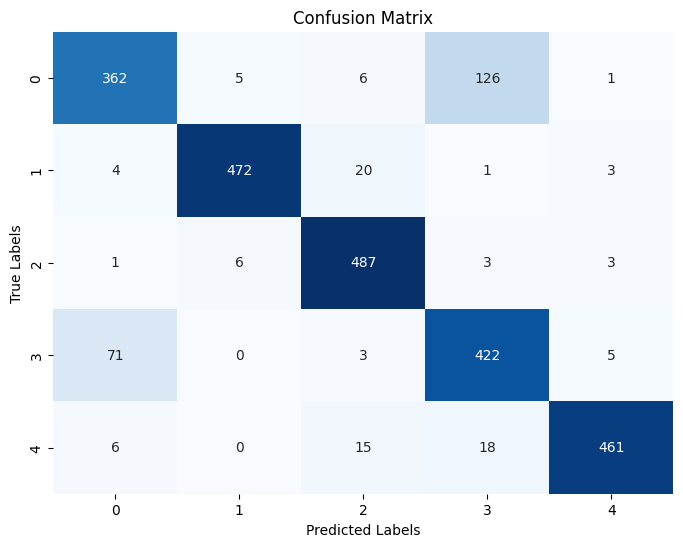

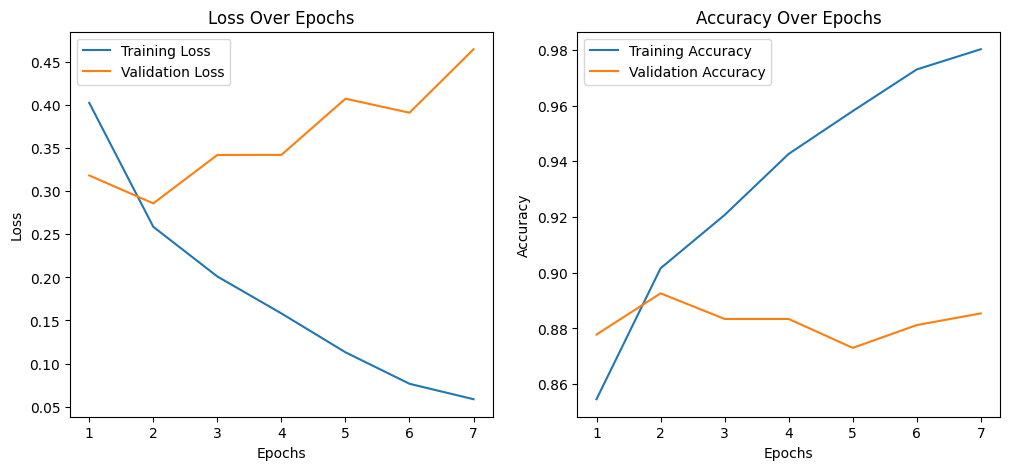

In [11]:
# Train and visualize the model's performance
train_val_cnn(num_epochs=10)

In [12]:
print(class_names)

# Function to load the model
def load_model(model_path, device):
    model = ResNet18_CNN().to(device)  # Initialize your model architecture and move it to the appropriate device
    model.load_state_dict(torch.load(model_path, map_location=device))  # Load the saved weights
    model.eval()  # Set the model to evaluation mode (important for inference)
    return model

# Function to preprocess the input image
def preprocess_image(image_path):
    # Define your image transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match model input size
        transforms.ToTensor(),          # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])
    
    image = Image.open(image_path)  # Open the image
    image = preprocess(image).unsqueeze(0)  # Preprocess and add batch dimension
    return image

# Function to classify the image
def classify_image(model, image_path, device):
    image_tensor = preprocess_image(image_path).to(device)  # Move the image tensor to the same device as the model
    with torch.no_grad():  # Disable gradient calculation for inference
        output = model(image_tensor)  # Forward pass
        _, predicted = torch.max(output, 1)  # Get the index of the max log-probability
    return predicted.item()  # Return the predicted class

# Load and display the image
def ret_show_img(model, image_path, device):
    image = mpimg.imread(image_path)
    plt.imshow(image)  # Display the image
    plt.axis('off')    # Turn off the axis for a cleaner look
    plt.show()

    predicted_class = classify_image(model, image_path, device)
    print(f'Predicted Class: {class_names[predicted_class]}')

    return image_path  # Return the image path (instead of numpy array)

model_path = './best_model.pth'

model = load_model(model_path, device)  # Load the model on the appropriate device (CPU/GPU)

['campus', 'archaelogical_excavation', 'junkyard', 'hospital', 'gift_shop']


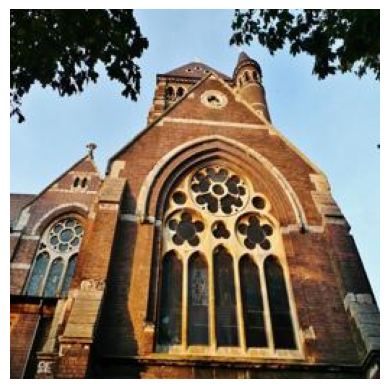

Predicted Class: campus


In [13]:
image_path_1 = ret_show_img(model, './data/test_256/Places365_test_00326404.jpg', device)

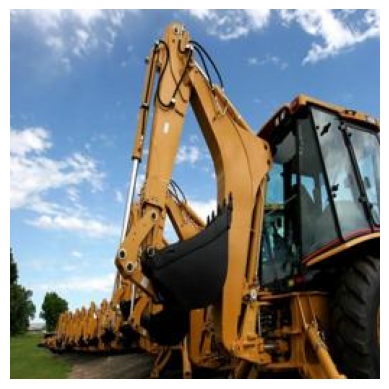

Predicted Class: junkyard


In [14]:
image_path_2 = ret_show_img(model, './data/test_256/Places365_test_00323926.jpg', device)

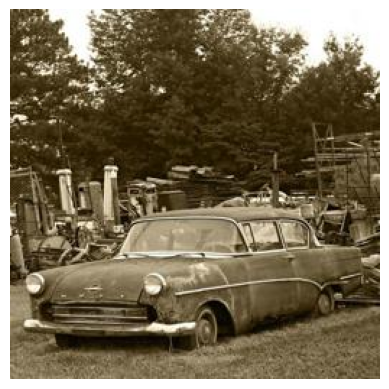

Predicted Class: junkyard


In [15]:
image_path_3 = ret_show_img(model, './data/test_256/Places365_test_00318167.jpg', device)

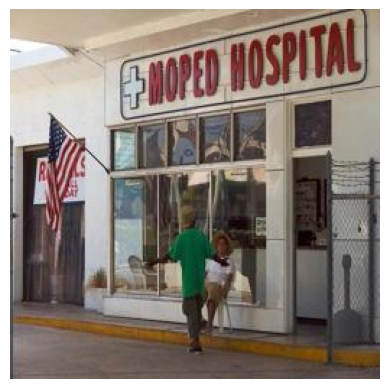

Predicted Class: gift_shop


In [16]:
image_path_4 = ret_show_img(model, './data/test_256/Places365_test_00323841.jpg', device)

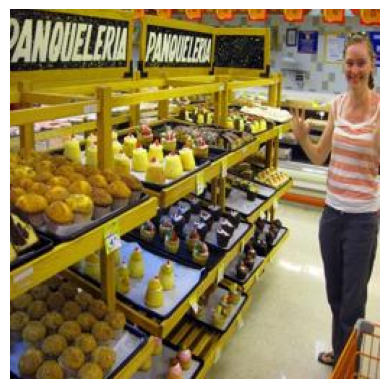

Predicted Class: gift_shop


In [17]:
image_path_5 = ret_show_img(model, './data/test_256/Places365_test_00321102.jpg', device)

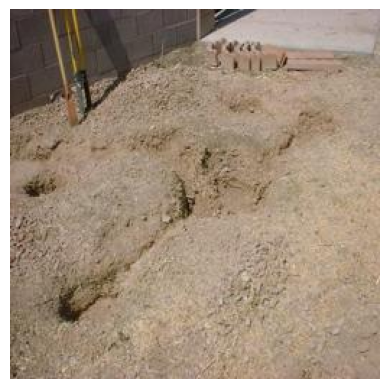

Predicted Class: archaelogical_excavation


In [18]:
image_path_6 = ret_show_img(model, './data/test_256/Places365_test_00322089.jpg', device)

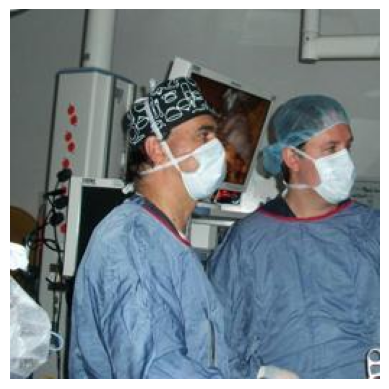

Predicted Class: hospital


In [19]:
image_path_7 = ret_show_img(model, './data/test_256/Places365_test_00315911.jpg', device)


Epoch 1/10
----------
  Batch 10/274 - Loss: 1.2531
  Batch 20/274 - Loss: 0.9203
  Batch 30/274 - Loss: 0.7487
  Batch 40/274 - Loss: 0.7230
  Batch 50/274 - Loss: 0.5599
  Batch 60/274 - Loss: 0.5738
  Batch 70/274 - Loss: 0.6322
  Batch 80/274 - Loss: 0.5701
  Batch 90/274 - Loss: 0.3730
  Batch 100/274 - Loss: 0.4767
  Batch 110/274 - Loss: 0.4131
  Batch 120/274 - Loss: 0.5723
  Batch 130/274 - Loss: 0.4039
  Batch 140/274 - Loss: 0.3814
  Batch 150/274 - Loss: 0.4532
  Batch 160/274 - Loss: 0.2305
  Batch 170/274 - Loss: 0.3639
  Batch 180/274 - Loss: 0.3529
  Batch 190/274 - Loss: 0.3957
  Batch 200/274 - Loss: 0.3305
  Batch 210/274 - Loss: 0.3162
  Batch 220/274 - Loss: 0.2931
  Batch 230/274 - Loss: 0.4592
  Batch 240/274 - Loss: 0.3096
  Batch 250/274 - Loss: 0.2857
  Batch 260/274 - Loss: 0.3223
  Batch 270/274 - Loss: 0.4074
Training Loss: 0.5290, Training Accuracy: 0.8273
Validation Loss: 0.3504, Validation Accuracy: 0.8688
  Validation loss decreased. Saving model...

E

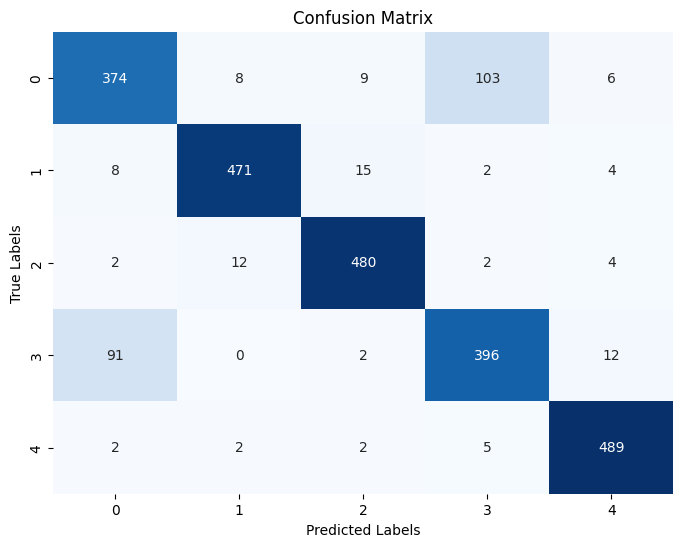

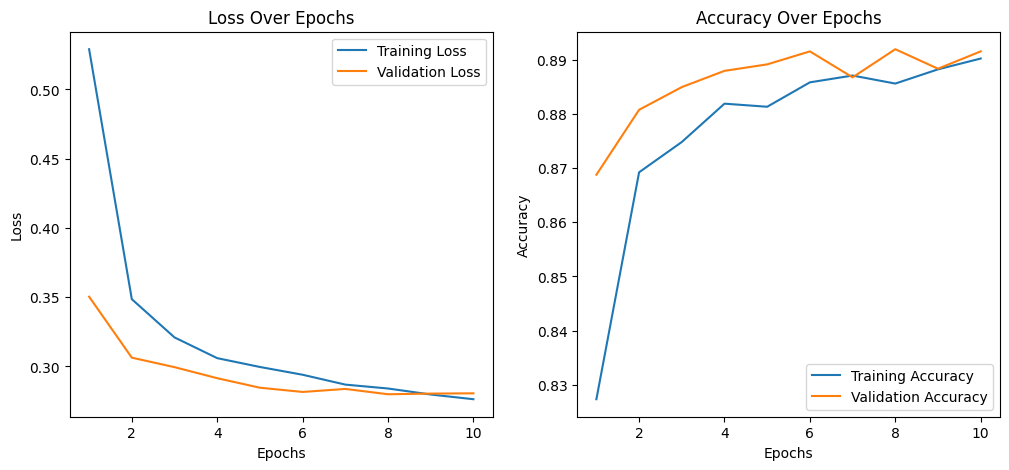

In [20]:
class MobileNetV2_CNN(nn.Module):
    def __init__(self, num_classes=5, freeze_mobilenet=True):
        super(MobileNetV2_CNN, self).__init__()
        
        # Load pre-trained MobileNetV2 model
        self.mobilenet_v2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        
        # Freeze model parameters if needed
        if freeze_mobilenet:
            for param in self.mobilenet_v2.parameters():
                param.requires_grad = False
        
        # Modify the classifier to fit the desired number of classes
        self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)
    
    def forward(self, x):
        return self.mobilenet_v2(x)

# Train and visualize the model's performance
train_val_cnn(model=MobileNetV2_CNN().to(device), num_epochs=10)


Epoch 1/10
----------
  Batch 10/274 - Loss: 1.2503
  Batch 20/274 - Loss: 0.9075
  Batch 30/274 - Loss: 0.7505
  Batch 40/274 - Loss: 0.7113
  Batch 50/274 - Loss: 0.5265
  Batch 60/274 - Loss: 0.5463
  Batch 70/274 - Loss: 0.5065
  Batch 80/274 - Loss: 0.3985
  Batch 90/274 - Loss: 0.5552
  Batch 100/274 - Loss: 0.5361
  Batch 110/274 - Loss: 0.3997
  Batch 120/274 - Loss: 0.3764
  Batch 130/274 - Loss: 0.5147
  Batch 140/274 - Loss: 0.3174
  Batch 150/274 - Loss: 0.5001
  Batch 160/274 - Loss: 0.4495
  Batch 170/274 - Loss: 0.3531
  Batch 180/274 - Loss: 0.4049
  Batch 190/274 - Loss: 0.4958
  Batch 200/274 - Loss: 0.3749
  Batch 210/274 - Loss: 0.3793
  Batch 220/274 - Loss: 0.3095
  Batch 230/274 - Loss: 0.3787
  Batch 240/274 - Loss: 0.3219
  Batch 250/274 - Loss: 0.2584
  Batch 260/274 - Loss: 0.4762
  Batch 270/274 - Loss: 0.3335
Training Loss: 0.5055, Training Accuracy: 0.8454
Validation Loss: 0.3386, Validation Accuracy: 0.8770
  Validation loss decreased. Saving model...

E

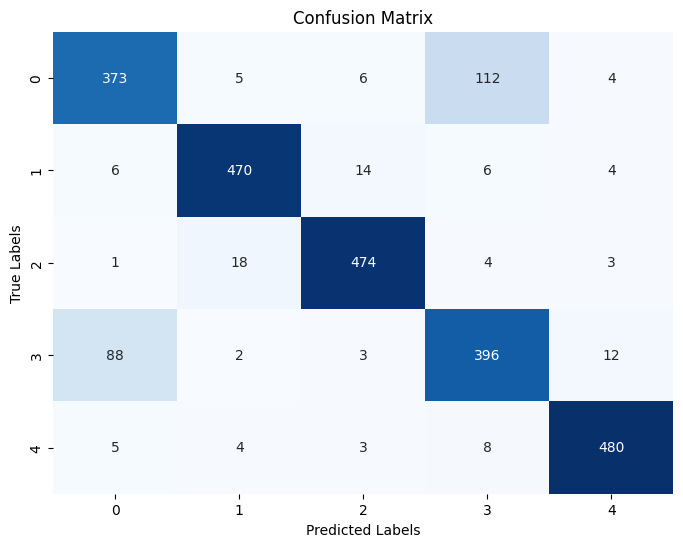

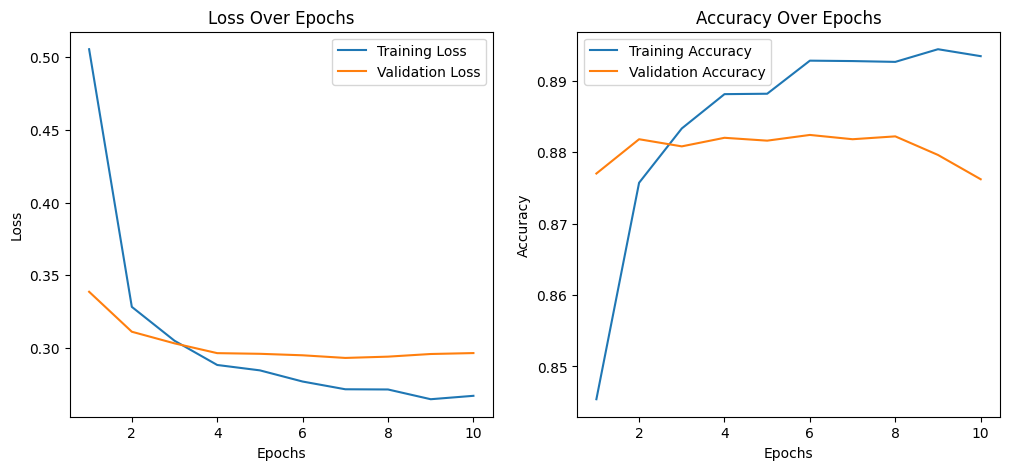

In [21]:
class MobileNetV3_CNN(nn.Module):
    def __init__(self, num_classes=5, freeze_mobilenet=True):
        super(MobileNetV3_CNN, self).__init__()
        
        # Load pre-trained MobileNetV3 model
        self.mobilenet_v3 = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
        
        # Freeze model parameters if needed
        if freeze_mobilenet:
            for param in self.mobilenet_v3.parameters():
                param.requires_grad = False
        
        # Modify the classifier to fit the desired number of classes
        self.mobilenet_v3.classifier[3] = nn.Linear(self.mobilenet_v3.classifier[3].in_features, num_classes)
    
    def forward(self, x):
        return self.mobilenet_v3(x)
    
# Train and visualize the model's performance
train_val_cnn(model=MobileNetV3_CNN().to(device), num_epochs=10)